In [2]:
%pylab
%matplotlib inline

import sys
import numpy as np
import scipy.cluster.hierarchy as sch
import pylab
import scipy
import matplotlib.pyplot as plt

# Add the ptdraft folder path to the sys.path list
sys.path.append('../src/')

import data_config as config
import networkx as nx

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
/Users/akivalipshitz/Developer/neuronal-analysis/data/wbdata/
Reading


In [18]:
adjacency = nx.adjacency_matrix(config.connectome_networkx.data()).toarray()


In [167]:
connectome = config.connectome_excel.data()

A = connectome['Connectome']['Origin']
B = connectome['Connectome']['Target']

alldata = np.concatenate((A,B))
nodes = np.unique(alldata)
class State():
  S = 1
  E = 2
  R = 3
  

neighbors = { }
state = { }
newstate = { }
for i in nodes:
  neighbors[i] = []
  state[i] = State.S
  newstate[i] = State.S


#drawing_colors = []

# Collects data for node_peers and node_index
#for c in xrange(0,len(nodes)):
#  graph.add_node(nodes[c])


for c in xrange(0, len(A)):
  neighbors[B[c]].append(A[c])



# let's get to work now
p=f=0.01

random.seed()
history = []
for step in xrange(0, 1000):
  for i in nodes:
    if (state[i] == State.S):
      if (random.random() < f):
        newstate[i] = State.E
      else: 
        for n in neighbors[i]:
          if state[n] == State.E:
            newstate[i] = State.E
    elif (state[i] == State.R):
      if (random.random() < p):
        newstate[i] = State.S
    elif (state[i] == State.E):
      newstate[i] = State.R
  for i in nodes:
    state[i] = newstate[i]

  history.append(newstate.values())



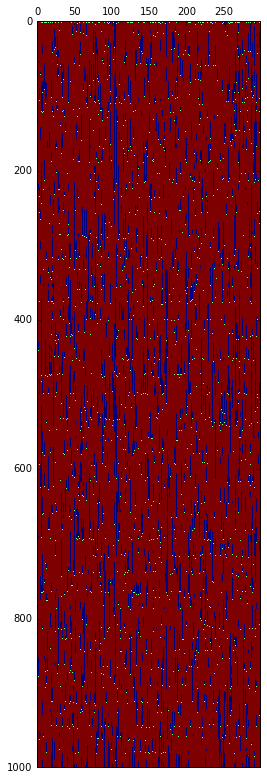

In [168]:
matshow(history)

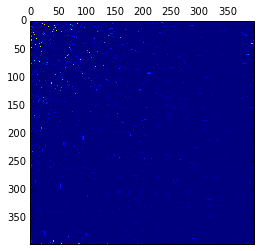

In [172]:
connectome = config.connectome_networkx.data()
matg = adjacency
import scipy.cluster.hierarchy as sch

Z = sch.linkage(matg, method='centroid')
indexs = sch.leaves_list(Z)
matg = matg[indexs][:,indexs]
matshow(matg)

In [173]:
from enum import Enum

nodes = connectome

class NeuronState():
  S = 1
  E = 2
  R = 3

class TopologicalSimulator: 
    f = 0.001
    p = 0.001
    def __init__(self, weights):
        self.nNodes = weights.shape[0]
        self.states = np.zeros(self.nNodes)
        self.states[:] = NeuronState.S
        self.weights = weights
        self.newstates = np.array(self.states)
    
    def step(self, f, p):
        self.newstates[:] = self.states
        # These are the state transitions
        S = self.newstates[self.states == NeuronState.S]
        probabilities = np.random.random_sample(size=S.shape[0])
        S[probabilities < f] = NeuronState.E

        for i in xrange(len(S)):
            matches = self.weights[i]>0
            neighbors = arange(397)[matches]
            isE = NeuronState.E in self.states[neighbors]  
            if isE: 
                self.newstates[i] = NeuronState.E
        
        self.newstates[self.states==NeuronState.S]=S

        R = self.newstates[self.states == NeuronState.R]
        probabilities = np.random.random_sample(size = R.shape[0])
        R[probabilities < p] = NeuronState.S
        self.newstates[self.states == NeuronState.R] = R
        
        self.newstates[self.states == NeuronState.E] = NeuronState.R
        self.states[:] = self.newstates
        
    def run(self, iterations, f,p):
        history = np.empty((iterations, self.nNodes))
        np.random.seed()
        for i in xrange(iterations):
            self.step(f,p)
            history[i] = np.array(self.states)
            
        return history

0.1 0.1
0.01 0.01
0.001 0.001
0.0001 0.0001
1e-05 1e-05
1e-06 1e-06


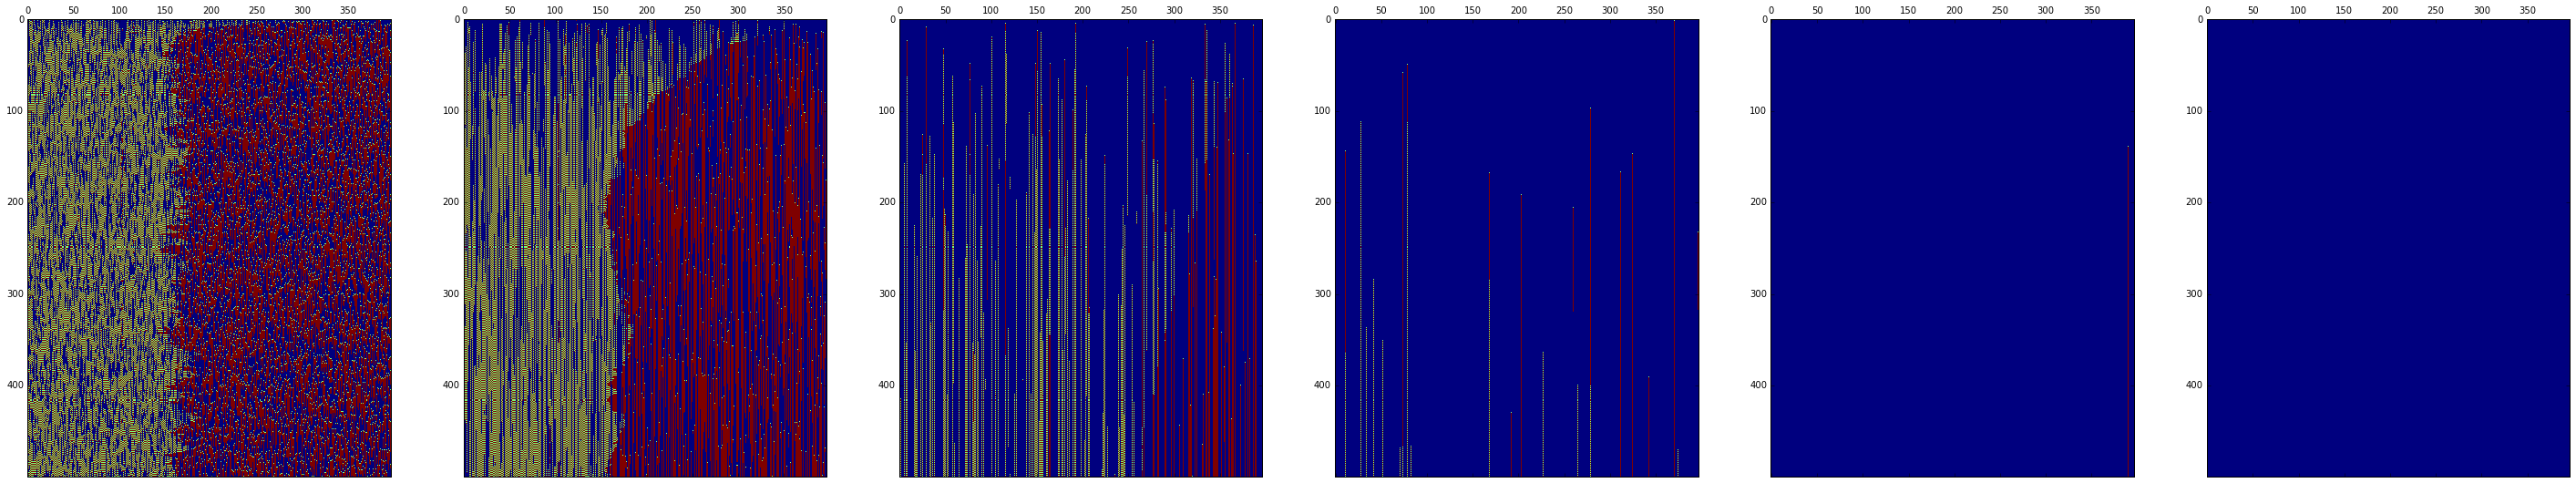

In [174]:
f,ax = subplots(1,6, figsize=(10*5, 20))

for j in range(6): 
    i = j+1
    sim = TopologicalSimulator(matg )
    f = p = 10**(-i)
    print f,p
    results1 = sim.run(500, f,p)
    ax[j].matshow(results1)
# matshow(results1)
savefig('/Users/akivalipshitz/Desktop/timeseries.jpg')


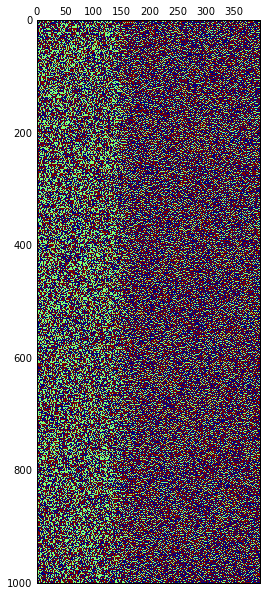

In [179]:
results2 = sim.run(1000,0.5,0.5)

figure(figsize=(10,20))
matshow(results2)